In [1]:
from sqlalchemy import *
import numpy as np
import pylab as plt
import pandas as pd
from peakdetect import peakdetect
from scipy.optimize import curve_fit 
%matplotlib inline

In [2]:
engine = create_engine('sqlite+pysqlite:///../SQL/75_8.db')
import time
start_time = time.time()
ADCdf = pd.io.sql.read_sql("SELECT * FROM ADC", engine)
Hitdf = pd.io.sql.read_sql("SELECT * FROM Hit", engine)
#PSAdf = pd.io.sql.read_sql("SELECT * FROM PSA", engine)
ProtoMapdf = pd.io.sql.read_sql("SELECT * FROM ProtoMap", engine)
RawADCdf = pd.io.sql.read_sql("SELECT * FROM RawADC", engine)
end_time = time.time()
print end_time-start_time

569.318471909


In [3]:
ADCdf = pd.io.sql.read_sql("SELECT * FROM ADC", engine)

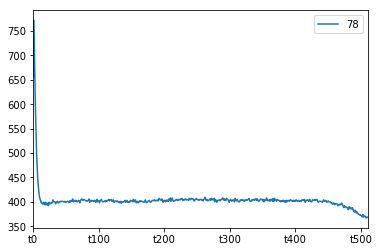

In [4]:
RawADCdf[(RawADCdf['EventID']==0)&(RawADCdf['PadNum']==70)].iloc[:,3:].T.plot()

(-15, 15)

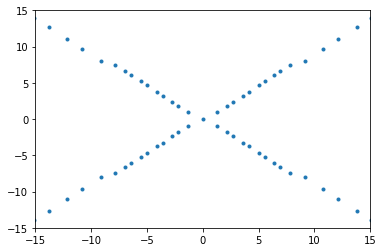

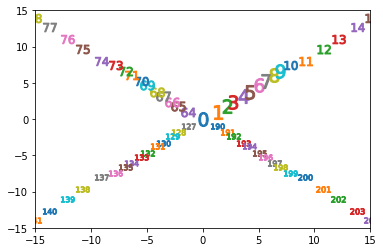

In [5]:
#print ProtoMapdf
plt.scatter(ProtoMapdf.iloc[:252]['PadX'],ProtoMapdf.iloc[:252]['PadY'],marker='.')
plt.xlim([-15,15])
plt.ylim([-15,15])
plt.figure()
for row in ProtoMapdf.iloc[:252].iterrows():
    plt.scatter(row[1]['PadX'],row[1]['PadY'],marker='${}$'.format(row[1]['PadNum']),s=200) 
plt.xlim([-15,15])
plt.ylim([-15,15])

In [6]:
def Process(Event):
    mesh = Event.iloc[:,3:][Event.iloc[:,3:]>20].sum(axis=0)
    #print mesh
    return mesh
start_time = time.time()
mesh_df = ADCdf.groupby('EventID').apply(Process)
end_time = time.time()
print end_time-start_time

def convolve(event):
    mesh_convol = np.convolve(event.values,([1]*10)[::-1],'same')
    return pd.Series(mesh_convol,index=['t'+str(i) for i in range(512)])
convol_df=mesh_df.apply(convolve,axis=1)
convol_df.reset_index(inplace=True)

8.5464220047


In [7]:
Hitdf = pd.io.sql.read_sql("SELECT * FROM Hit", engine)

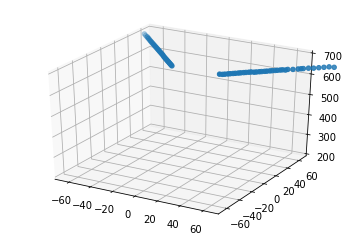

In [124]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
dftmp = Hitdf[(Hitdf['EventID']==12)&(Hitdf['charge']>30)]
ax = plt.subplot(111, projection='3d')
ax.scatter(dftmp['x'],dftmp['y'],dftmp['z'])
ax.set_zlim([200,700]);
ax.set_xlim([-70,70]);
ax.set_ylim([-70,70]);

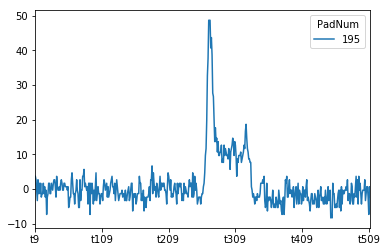

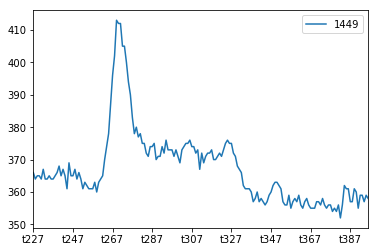

In [9]:
EID=5
PadNum = 195
tmpdf = ADCdf[(ADCdf['EventID']==EID)].iloc[:,2:]
tmpdf =  tmpdf[tmpdf.iloc[:,10:-10].max(axis=1)>20]
%matplotlib inline
tmpdf=tmpdf.set_index(tmpdf['PadNum'])
#tmpdf
tmpdf[(tmpdf['PadNum']>=PadNum)&(tmpdf['PadNum']<=PadNum)].iloc[:,10:].T.plot()
#tmpdf.iloc[60:70,1:].T.plot()
plt.figure()
RawADCdf[(RawADCdf['EventID']==EID)&(RawADCdf['PadNum']==PadNum)].iloc[:,230:400].T.plot()
#tmpdf['PadNum']

(100, 500)

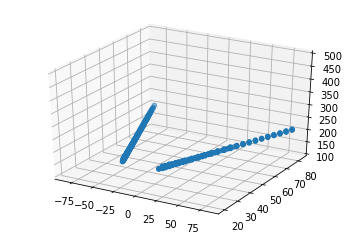

In [123]:
EID=12
adc_map_df = pd.merge(ADCdf[ADCdf['EventID']==EID],ProtoMapdf,on='PadNum')
hitdf = pd.melt(adc_map_df,id_vars=['EventID','PadNum','PadX','PadY'],value_vars=['t'+str(i) for i in range(512)])
hitdf.columns = ['EventID','PadNum','PadX','PadY','PadZ','C']
hitdf['PadZ']=hitdf['PadZ'].str.lstrip('t').astype(np.int)
tmpdf = hitdf[hitdf['C']>50]

#hitdf['C'].hist(bins=100)
#plt.gca().set_yscale('log')
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
ax = plt.subplot(111, projection='3d')
ax.scatter(tmpdf['PadX'],tmpdf['PadY'],tmpdf['PadZ'])
#ax.set_xlim([-10,10])
#ax.set_ylim([0,700])
ax.set_zlim([100,500])

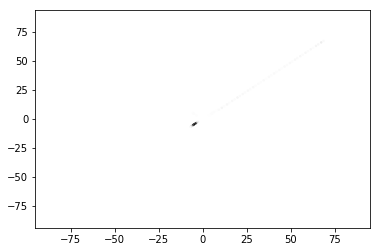

In [97]:
sub1 = ADCdf[ADCdf['EventID']==11]
sub2 = pd.merge(sub1,ProtoMapdf,on='PadNum')
sub2['total'] = sub2.iloc[:,3:515][sub2.iloc[:,3:515]>20].sum(axis=1)
c = sub2['total'].values/max(sub2['total'])
plt.scatter(sub2['PadX'],sub2['PadY'],s=2,c=zip(1-c,1-c,1-c))
#plt.xlim([-10,10])
#plt.ylim([-10,10])

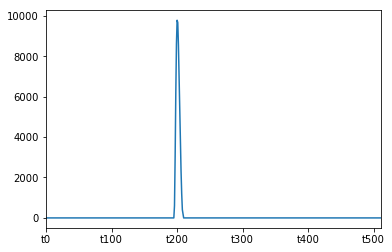

In [114]:
mesh_df.ix[12].T.plot()

In [30]:
%load_ext Cython

In [32]:
%%cython
def f_plain(x):
    return x * (x - 1)

In [35]:
def Gaussian(x,h,x0,sigma):
    return h*np.exp(-(x-x0)*(x-x0)/(2*sigma*sigma))#/(np.sqrt(2*np.pi)*sigma)

In [34]:
def tbjcPeakFinder(data,lookahead=10,delta=10,th=0.05,mini = 50):
    data = np.array(data)
    peaks = peakdetect(data,lookahead=10,delta=10)
    peaks = peaks[0]+peaks[1]
    Max = sorted(peaks, key =lambda x:x[1])[-1]
    ps = [p for p in peaks if p[1]>=Max[1]*th and p[1]>mini]
    param = []
    for x,y in ps:
        std = delta
        h = y
        x0 = x
        xx = range(data.shape[0])[int(x0-3*delta):int(x0+3*delta)]
        yy = data[int(x0-3*delta):int(x0+3*delta)]
        popt, pcov = curve_fit(Gaussian,xx,yy,p0=[h,x0,std],bounds=[[h*0.9,x0-std,std*0.01],[h*1.1,x0+std,std*100]])
        param.append(popt)
        
    return param

[array([ 1645.22755947,   205.30441137,     3.88174632]), array([ 109.09122667,  269.41909189,    3.2055779 ])]
[ 1645.22755947   205.30441137     3.88174632]
area: 16008.2205694
15906.0999074
[ 109.09122667  269.41909189    3.2055779 ]
area: 876.568974833
850.0


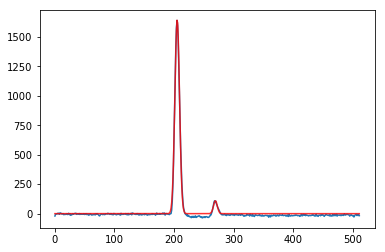

In [15]:
tmp = ADCdf[(ADCdf['EventID']==5)&(ADCdf['PadNum']>195)&(ADCdf['PadNum']<250)].copy()
tmpOdd = tmp[tmp['PadNum']%2==1].copy()
tmpEven = tmp[tmp['PadNum']%2==0].copy()
tmpOdd['PadNum1'] = (tmpOdd['PadNum']-1).values
tmp1 = pd.merge(tmpOdd,tmpEven,left_on='PadNum1',right_on='PadNum')

name1 = [n for n in tmp1.columns if n[-2:]=='_x' and n[0]=='t']
name2 = [n for n in tmp1.columns if n[-2:]=='_y' and n[0]=='t']
#tmpx = tmp1[name1]
#tmpy = tmp1[name2]
#tmp[(tmp['PadNum']<230)&(tmp['PadNum']>190)].T.iloc[180:330,:].plot()
plt.figure()
#print tmp
EID= [1396,1401,1445]
#print tmp.ix[EID].iloc[:,3:]
data= tmp.ix[EID].iloc[:,3:].sum(axis=0)
plt.plot(data.values)
param = tbjcPeakFinder(data)
yy = np.zeros(512)
print param
for p in param:
    xx = np.array(range(512))
    yy += Gaussian(xx,*p)
    print p
    print "area:",p[0]*p[2]*np.sqrt(np.pi*2)
    print data[int(3+p[1]-p[2]*3):int(3+p[1]+p[2]*3)].sum()
plt.plot(xx,yy,c=(1,0,0,0.8))

#plt.xlim([150,250])

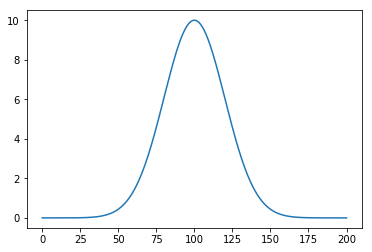

In [16]:
x = np.linspace(0,200,1000)
plt.plot(x,Gaussian(x,10,100,20))

In [17]:
mask1 = (ADCdf['PadNum']>11)&(ADCdf['PadNum']<=63)
mask2 = (ADCdf['PadNum']>200)&(ADCdf['PadNum']<=252)
mask3 = (ADCdf['PadNum']>137)&(ADCdf['PadNum']<=189)
mask4 = (ADCdf['PadNum']>74)&(ADCdf['PadNum']<=126)
mask5 =  ADCdf.iloc[:,3:].max(axis=1)>50
mask = (mask1|mask2|mask3|mask4)&mask5
Outdf = ADCdf[mask]
tmpOdd = Outdf[Outdf['PadNum']%2==1].copy()
tmpEven = Outdf[Outdf['PadNum']%2==0].copy()
tmpOdd['PadNum1'] = (tmpOdd['PadNum']+(-1)**((tmpOdd['PadNum']-1)/63).astype(int)).values
tmp1 = pd.merge(tmpOdd,tmpEven,left_on=['PadNum1','EventID'],right_on=['PadNum','EventID'])
Pairdf = tmp1.drop(['ID_x','ID_y','PadNum1'],1)

,PadNum_x,PadNum_y
10,219,218


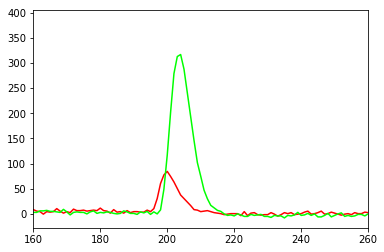

In [18]:
tmp = tmp1.iloc[:,range(0,512+2)+range(514,515+512)]
plt.plot(tmp1.iloc[0:1,range(2,512+2)].values.T,c=(1,0,0));
plt.plot(tmp1.iloc[0:1,range(515,515+512)].T.values,c=(0,1,0));
plt.xlim([160,260])
#for o in tmp1.columns.values:
#    print o
tmp1.iloc[10:11][['PadNum_x','PadNum_y']]
#tmp1.iloc[:,range(2,512+2)+range(515,515+512)].iloc[:100,:512].T.plot(legend=None);

In [54]:
def Process(r):
    data = r.iloc[0,3:].values
    ch,pos,ind = [],[],[]
    #print type(r.iloc[0,2].astype(int))
    try:
        param = tbjcPeakFinder(data)
        for idx,p in enumerate(param):
            c = data[int(p[1]-p[2]*3):int(p[1]+p[2]*3)].sum()
            pos.append(p[1])
            ch.append(c)
    except:
        pass
    return  pd.DataFrame({'EventID':[r.iloc[0,1].astype(int)]*len(pos),'PadNum':[r.iloc[0,2].astype(int)]*len(pos),'Peak Pos':pos,'charge':ch})
    
r1 = Outdf.groupby('ID').apply(Process)
#print r.reset_index(drop=True)


(-75, 75)

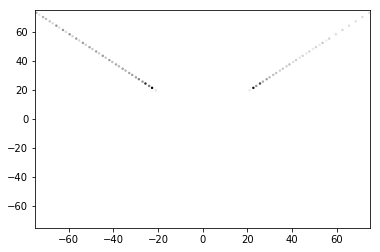

In [109]:
sub1 = pd.merge(r1,ProtoMapdf,on='PadNum')
sub2 = sub1[sub1['EventID']==12].copy()
sub2[sub2['charge']<0] = 0
c = sub2['charge'].values/max(sub2['charge'])

plt.scatter(sub2['PadX'],sub2['PadY'],s=2,c=zip(1-c,1-c,1-c))
plt.xlim([-75,75])
plt.ylim([-75,75])

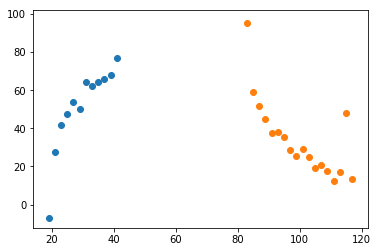

In [122]:
tmpOdd = r1[r1['PadNum']%2==1].copy()
tmpEven = r1[r1['PadNum']%2==0].copy()
tmpOdd['PadNum1'] = (tmpOdd['PadNum']+(-1)**((tmpOdd['PadNum']-1)/63).astype(int)).values
tmp1 = pd.merge(tmpOdd,tmpEven,left_on=['PadNum1','EventID'],right_on=['PadNum','EventID'])
def PhiCal(r):
    phi = -1
    phi = 45+45*(r['charge_x']-r['charge_y'])/(r['charge_x']+r['charge_y'])*(3.2+0.5)/(3.2-0.5)

    return phi
tmp1['phi'] = tmp1.apply(PhiCal,axis=1)
rr = tmp1[(tmp1['EventID']==12)&((tmp1['PadNum_x']>10)&((tmp1['PadNum_x']<60)))]
plt.scatter(rr['PadNum_x'],rr['phi'])
rr= tmp1[(tmp1['EventID']==12)&((tmp1['PadNum_x']>64)&((tmp1['PadNum_x']<120)))]
plt.scatter(rr['PadNum_x'],rr['phi'])


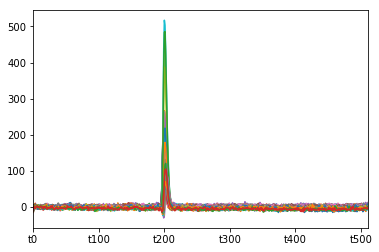

In [113]:
Outdf[(Outdf['EventID']==12)].iloc[:,3:].T.plot(legend=False)